# Content Based Filtering

By: Nandakishore Vinayakrishnan - 23070854

In [90]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras import backend as K
from keras import Input, Model
from keras.layers import Dense, Dropout
import tensorflow as tf


df = pd.read_csv('../tmdb_5000_movies.csv')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [91]:
column_info = df.dtypes
print(column_info)

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object


## Steps:

1. Identify the columns to drop
    * Drop 'homepage', 'original_language', 'popularity', 'release_date', 'status', 'original_title', 'vote_average', 'vote_count'
2. Extract the genres, keywords, and production companies from their respective columns
3. Feature Engineering
4. Implementing Neural Network model
5. Model Evaluation

# Data Preprocessing

### Step 1: Identify the columns to drop

The columns to drop are:

1. 'budget'
2. 'homepage'
3. 'original_language'
4. 'original_title'
5. 'release_date'
6. 'spoken_languages'
7. 'status'
8. 'revenue'
9. 'vote_average'
10. 'vote_count'
11. 'popularity'

These columns were removed because we didn't see a reason to implement them in the model since they have very little important metadata.

In [92]:
drop_cols = ['budget', 'homepage', 'original_language', 
            'original_title', 'release_date', 'spoken_languages', 
            'status', 'revenue', 'vote_average', 
            'vote_count', 'popularity']
df = df.drop(drop_cols, axis=1)

### Step 2: Extract metadata from columns

In [93]:
def extract_features(x):
    return [i['name'] for i in ast.literal_eval(x)] if pd.notnull(x) else []

df['genres_list'] = df['genres'].apply(extract_features)
df['keywords_list'] = df['keywords'].apply(extract_features)
df['production_companies'] = df['production_companies'].apply(extract_features)
df['production_countries'] = df['production_countries'].apply(extract_features)

### Step 3: Feature Engineering

Encode the genres using MultiLabelBinarizer, and vectorize movie overview using TfidfVectorizer.

In [94]:
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(df['genres_list'])
keywords_features = mlb.fit_transform(df['keywords_list'])
production_companies_features = mlb.fit_transform(df['production_companies'])
production_countries_features = mlb.fit_transform(df['production_countries'])

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
overview_features = tfidf.fit_transform(df['overview'].fillna(''))
title_features = tfidf.fit_transform(df['title'])
tagline_features = tfidf.fit_transform(df['tagline'].fillna(''))

Stack the encoded genres and vectorized movie overview into a single array, X, which is the model input.

In [95]:
X = np.hstack([
    genre_features, 
    keywords_features,
    production_companies_features,
    production_countries_features,
    overview_features.toarray(),
    title_features.toarray(), 
    tagline_features.toarray()
    ])

### Step 4: Implementing the Neural Network Model

The model is implemented using a simple neural network with 3 hidden layers and a dropout layer to prevent overfitting.

The network architecture is as follows:
1. Input Layer
2. Dense layer with [128, 192, 256, 320, 384, 448 or 512] units and ReLU activation
3. Dropout layer with [0.1, 0.2, 0.3, 0.4, or 0.5] dropout rate
4. Dense layer with [64, 96, 128, 160, 192, 224, or 256] units and ReLU activation
5. Dense layer with [32, 48, 64, 80, 96, 112, or 128] units and ReLU activation
6. Embedding layer with 64 units to capture compressed representation of the input
7. Output layer with same number of units as input dimensions + linear activation function

Utilizes the Adam optimizer, and has a cosine_similarity_loss loss function. 
The model is trained for 20 epochs with a batch size of 32.

In [96]:
def recall_at_k(y_true, y_pred, k=10):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Get the top k predictions
    _, top_k_indices = tf.nn.top_k(y_pred, k=k)
    
    # Create a binary tensor of the top k predictions
    top_k_predictions = tf.reduce_sum(tf.one_hot(top_k_indices, depth=y_pred.shape[1]), axis=1)
    
    # Calculate the recall
    true_positives = tf.reduce_sum(top_k_predictions * y_true, axis=1)
    possible_positives = tf.reduce_sum(y_true, axis=1)
    recall = true_positives / (possible_positives + K.epsilon())
    
    return tf.reduce_mean(recall)

In [97]:
def cosine_similarity_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=1))

In [98]:
def build_model(hp):
    input_dim = X.shape[1]
    embedding_dim = 64

    input_layer = Input(shape=(input_dim,))
    dense_1 = Dense(hp.Int('units_1', min_value=128, max_value=512, step=64), activation='relu')(input_layer)
    dropout_1 = Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(dense_1)
    dense_2 = Dense(hp.Int('units_2', min_value=64, max_value=256, step=32), activation='relu')(dropout_1)
    dense_3 = Dense(hp.Int('units_3', min_value=32, max_value=128, step=16), activation='relu')(dense_2)
    embedding = Dense(embedding_dim, name='embedding')(dense_3)
    output_layer = Dense(input_dim, activation='linear')(embedding)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss=cosine_similarity_loss, metrics=[recall_at_k])
    return model

tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_recall_at_k", direction="max"),
    max_epochs=20,
    factor=3,
    directory='results',
    project_name='content_filtering'
)

tuner.search(X, X, epochs=20, batch_size=32, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# WARNING: This model will take a lot of time to train. Approximately 30min.

print("""
    Optimal number of units in first densely-connected layer: {}
    Optimal dropout rate: {}
    Optimal number of units in second densely-connected layer: {}
    Optimal number of units in third densely-connected layer: {}
    """.
    format(best_hps.get('units_1'), best_hps.get('dropout_1'), best_hps.get('units_2'), best_hps.get('units_3'))
)

model = tuner.hypermodel.build(best_hps)
history = model.fit(X, X, epochs=20, batch_size=32, validation_split=0.2)

Trial 30 Complete [00h 02m 23s]
val_recall_at_k: 0.2541554272174835

Best val_recall_at_k So Far: 0.2679928243160248
Total elapsed time: 00h 30m 36s

    Optimal number of units in first densely-connected layer: 256
    Optimal dropout rate: 0.1
    Optimal number of units in second densely-connected layer: 224
    Optimal number of units in third densely-connected layer: 128
    
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.8116 - recall_at_k: 0.1401 - val_loss: 0.6907 - val_recall_at_k: 0.1909
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.6500 - recall_at_k: 0.1900 - val_loss: 0.6228 - val_recall_at_k: 0.2106
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.5981 - recall_at_k: 0.2112 - val_loss: 0.5894 - val_recall_at_k: 0.2222
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.5716 - recall_at_k: 0.2237 - val_loss: 0.5694 - val_recall_at_k: 0.2273
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.5509 - recall

Pulls activations from embedding layer and uses them as the output of the model.

In [99]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)
embeddings = embedding_model.predict(X)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Step 5: Model Evaluation

Function takes a TMDB ID as input and returns the top 10 recommendations based on cosine simularity between the **embeddings** of the input movie & **embeddings** of all other movies in the dataset.

Simularity scores are sorted in descending order and the top 10 movies with highest sim scores are returned.

In [100]:
def nn_recommend(tmdb_id, n=10):
    try:
        idx = df[df['id'] == tmdb_id].index[0]
    except:
        return ["Movie not found"]
    
    sim_scores = cosine_similarity([embeddings[idx]], embeddings)[0]
    top_indices = sim_scores.argsort()[-n-1:-1][::-1]
    
    return [f"{row['id']} - {row['title']} ({sim_scores[i] * 100:.2f}%)" for i, row in df.iloc[top_indices].iterrows()]

In [101]:
nn_recommend(24428) # The Avengers

['102899 - Ant-Man (93.65%)',
 '100402 - Captain America: The Winter Soldier (93.48%)',
 '99861 - Avengers: Age of Ultron (92.94%)',
 '271110 - Captain America: Civil War (92.71%)',
 '1726 - Iron Man (87.05%)',
 '68721 - Iron Man 3 (87.01%)',
 '76338 - Thor: The Dark World (86.92%)',
 '1771 - Captain America: The First Avenger (85.66%)',
 '10138 - Iron Man 2 (85.51%)',
 '118340 - Guardians of the Galaxy (81.98%)']

In [102]:
nn_recommend(206647) # Spectre

['37724 - Skyfall (71.39%)',
 '235 - Stand by Me (65.99%)',
 '10764 - Quantum of Solace (64.48%)',
 '299687 - The 5th Wave (63.74%)',
 "9471 - Charlie's Angels: Full Throttle (61.73%)",
 '335778 - Risen (60.73%)',
 '7451 - xXx (60.29%)',
 "80274 - Ender's Game (60.08%)",
 '82700 - After Earth (59.25%)',
 "4327 - Charlie's Angels (59.04%)"]

### Embedding Visualization

Visualize the embeddings using PCA to understand the clustering of similar movies.

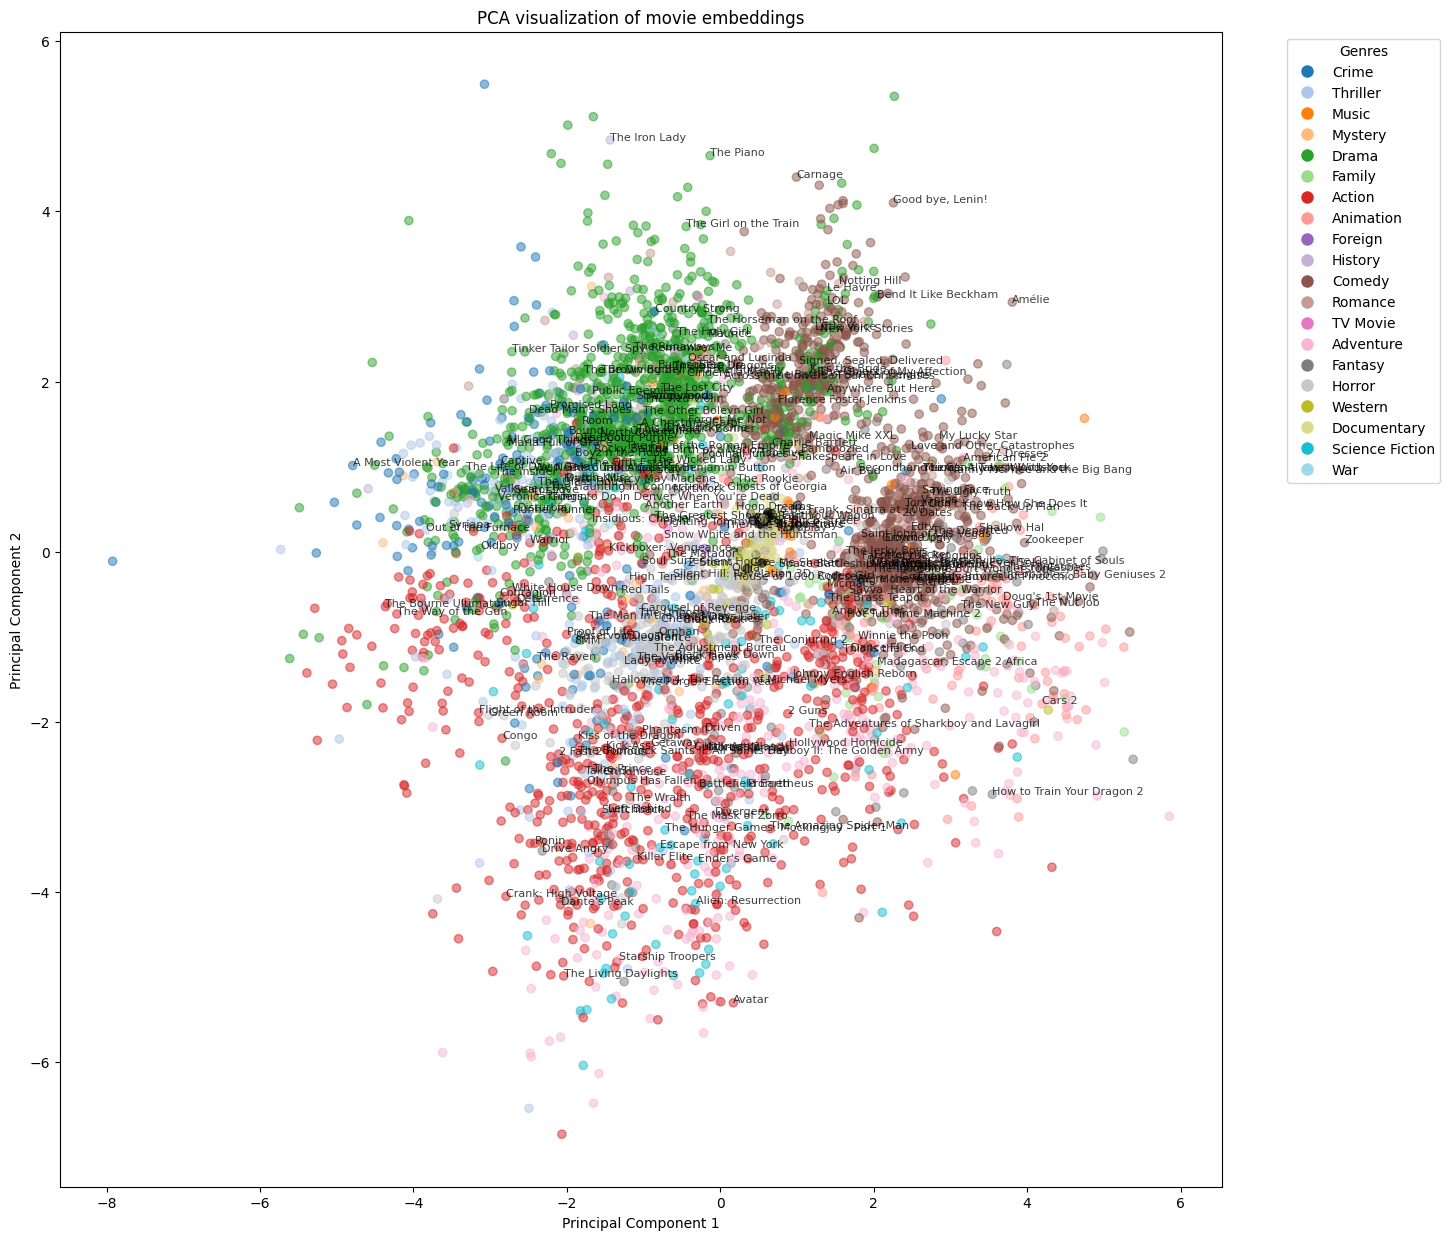

In [103]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

unique_genres = set([genre for sublist in df['genres_list'] for genre in sublist])
palette = sns.color_palette("tab20", len(unique_genres))
genre_color_map = {genre: palette[i] for i, genre in enumerate(unique_genres)}

colors = [genre_color_map[df['genres_list'].iloc[i][0]] if df['genres_list'].iloc[i] else (0, 0, 0) for i in range(len(df))]

plt.figure(figsize=(15, 15))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.5)

for i in range(0, len(df), 20):  # Label every 20th point
    plt.annotate(df['title'].iloc[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.75)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=genre_color_map[genre], markersize=10) for genre in unique_genres]
plt.legend(handles, unique_genres, title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('PCA visualization of movie embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()